In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

#Process data
OrderSet = pd.read_csv('OrderSet.csv')
PriceSet = pd.read_excel('SecondPriceSet.xlsx')
#generating the mid price of b/o spread for each second
PriceSet['Mid'] = (PriceSet['Bid']+PriceSet['Ask'])/2
PriceSet['Spread'] = PriceSet['Ask']- PriceSet['Bid']
#change the date and time in Orderset to the same format
OrderSet['Time'] = pd.to_datetime(OrderSet['Time'])

Market Taking (MT) -- for each order, you will aggress the market immediately and therefore incur the (half) Bid/Offer spread

In [2]:
pnl_MT = []
j = 0
for i in range(len(OrderSet)):
    while(j < len(PriceSet) and OrderSet['Time'][i]!= PriceSet['Time'][j]):
        j +=1
    pnl_MT.append(- PriceSet['Spread'][j]/2)
    
pnl_MT = [x*10000 for x in pnl_MT]

sum(pnl_MT)

-60.050000000343424

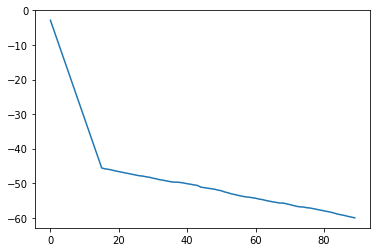

In [18]:
plt.plot(list(np.cumsum(pnl_MT)))

Opportunistic Market Making (OMM)
--for each order, you will rest it within the Bid/Offer spread, for a given amount of time, waiting for its (possible) opportunistic execution
First Way: OMMSide---joining “your side” of the market

In [3]:
#a max Stop Loss (SL)
SL = 0.0002
#a max Time to Execution (TTE)
TTE = 10

pnl_OMMSide = []
j = 0

#for analysis
exe_time = []
SL_trig = []
TTE_trig = []

for i in range(len(OrderSet)):
    while(j < len(PriceSet)-1 and OrderSet['Time'][i]!= PriceSet['Time'][j]):
        j +=1
    #j is the index at order time
    #a buy order, set price at bid side.
    time_limit = j + TTE
    x = j #use a new iterator,represent the time after an order is made
    
    if OrderSet['Side'][i] == 'B':
        bid_price = PriceSet['Bid'][x]
        #if the ask price equals or lower than my bid price or the time limit is reached, execute immediately using ask price.
        while x < time_limit and PriceSet['Ask'][x] > bid_price and (PriceSet['Ask'][x] - PriceSet['Mid'][j]) < SL :
            x += 1
        #if ask <= my bid, execute at my bid price, else execute at ask price
        if PriceSet['Ask'][x] <= bid_price:
            pnl_OMMSide.append(PriceSet['Mid'][j]-bid_price)
        else:
            pnl_OMMSide.append(PriceSet['Mid'][j]-PriceSet['Ask'][x])
            
        exe_time.append(x-j)
        if (PriceSet['Ask'][x] - PriceSet['Mid'][j]) >= SL:
            SL_trig.append('SL')
        else:
            SL_trig.append('/n')
        if (x >= time_limit):
            TTE_trig.append('TTE')
        else:
            TTE_trig.append('/n')
            
    if OrderSet['Side'][i] == 'S':
        ask_price = PriceSet['Ask'][x]
        #if the bid price is equal or higher than my ask price or the time limit is reached, execute immediately using bid price.
        while x < time_limit and PriceSet['Bid'][x] < ask_price and (PriceSet['Mid'][j] - PriceSet['Bid'][x]) < SL:
            x +=1
            
        if PriceSet['Bid'][x]>=ask_price:
            pnl_OMMSide.append((ask_price - PriceSet['Mid'][j]))
        else:
            pnl_OMMSide.append((PriceSet['Bid'][x] - PriceSet['Mid'][j]))
            
        exe_time.append(x-j)
        if (PriceSet['Mid'][j] - PriceSet['Bid'][x]) >= SL:
            SL_trig.append('SL')
        else:
            SL_trig.append('/n')
            
        if (x >= time_limit):
            TTE_trig.append('TTE')
        else:
            TTE_trig.append('/n')

pnl_OMMSide = [x*10000 for x in pnl_OMMSide]
OMMSide = pd.DataFrame(pnl_OMMSide, columns = ['PnL'])
OMMSide['Execution time'] = exe_time
OMMSide['SL'] = SL_trig
OMMSide['TTE'] = TTE_trig

In [4]:
OMMSide.to_csv('OMMSide.csv')

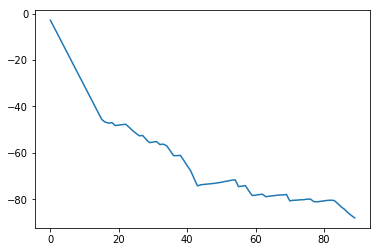

In [5]:
plt.plot(list(np.cumsum(pnl_OMMSide)))

OMMMid---resting your order at mid-market 

In [6]:
#a max Stop Loss (SL)
SL = 0.0002
#a max Time to Execution (TTE)
TTE = 10

pnl_OMMMid = []
j = 0

#for analysis
exe_time = []
SL_trig = []
TTE_trig = []

for i in range(len(OrderSet)):
    while(j < len(PriceSet)-1 and OrderSet['Time'][i]!= PriceSet['Time'][j]):
        j +=1
    #j is the index at order time
    #a buy order, set price at bid side.
    time_limit = j + TTE
    x = j #use a new iterator,represent the time after an order is made
    
    if OrderSet['Side'][i] == 'B':
        bid_price = PriceSet['Mid'][x]
        #if the ask price equals or lower than my bid price or the time limit is reached, execute immediately using ask price.
        while x < time_limit and PriceSet['Ask'][x] > bid_price and (PriceSet['Ask'][x] - PriceSet['Mid'][j]) < SL :
            x += 1
        #if ask <= my bid, execute at my bid price, else execute at ask price
        if PriceSet['Ask'][x] <= bid_price:
            pnl_OMMMid.append(PriceSet['Mid'][j]-bid_price)
        else:
            pnl_OMMMid.append(PriceSet['Mid'][j]-PriceSet['Ask'][x])
            
        exe_time.append(x-j)
        if (PriceSet['Ask'][x] - PriceSet['Mid'][j]) >= SL:
            SL_trig.append('SL')
        else:
            SL_trig.append('/n')
        if (x >= time_limit):
            TTE_trig.append('TTE')
        else:
            TTE_trig.append('/n')
            
    if OrderSet['Side'][i] == 'S':
        ask_price = PriceSet['Mid'][x]
        #if the bid price is equal or higher than my ask price or the time limit is reached, execute immediately using bid price.
        while x < time_limit and PriceSet['Bid'][x] < ask_price and (PriceSet['Mid'][j] - PriceSet['Bid'][x]) < SL:
            x +=1
            
        if PriceSet['Bid'][x]>=ask_price:
            pnl_OMMMid.append((ask_price - PriceSet['Mid'][j]))
        else:
            pnl_OMMMid.append((PriceSet['Bid'][x] - PriceSet['Mid'][j]))
            
        exe_time.append(x-j)
        if (PriceSet['Mid'][j] - PriceSet['Bid'][x]) >= SL:
            SL_trig.append('SL')
        else:
            SL_trig.append('/n')
            
        if (x >= time_limit):
            TTE_trig.append('TTE')
        else:
            TTE_trig.append('/n')
            
pnl_OMMMid = [x*10000 for x in pnl_OMMMid] 
OMMMid = pd.DataFrame(pnl_OMMMid, columns = ['PnL'])
OMMMid['Execution time'] = exe_time
OMMMid['SL'] = SL_trig
OMMMid['TTE'] = TTE_trig



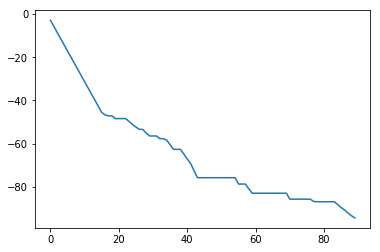

In [7]:
plt.plot(list(np.cumsum(pnl_OMMMid)))

In [8]:
OMMMid.to_csv('OMMMid.csv')

In [9]:
#total PnL
print(sum(pnl_MT))
print(sum(pnl_OMMSide))
print(sum(pnl_OMMMid))

-60.050000000343424
-88.04999999985074
-94.49999999984638


In [10]:
#avg PnL
print(np.mean(pnl_MT))
print(np.mean(pnl_OMMSide))
print(np.mean(pnl_OMMMid))

-0.6672222222260383
-0.9783333333316749
-1.0499999999982932


In [11]:
print(np.median(pnl_MT))
print(np.median(pnl_OMMSide))
print(np.median(pnl_OMMMid))

-0.20000000000020002
-0.5749999999749011
-0.27499999997515623


In [12]:
print(np.mean(OMMSide['Execution time']))
print(np.mean(OMMMid['Execution time']))

4.622222222222222
4.166666666666667


In [13]:
print(np.median(OMMSide['Execution time']))
print(np.median(OMMMid['Execution time']))

3.0
3.0


In [14]:
sl_OMMSide = 0
sl_OMMMid = 0
for i in range(len(OMMSide)-1):
    if OMMSide['SL'][i] == 'SL':
        sl_OMMSide +=1
    if OMMMid['SL'][i] =='SL':
        sl_OMMMid +=1
        
print(sl_OMMSide)
print(sl_OMMMid)

27
27


In [15]:
tte_OMMSide = 0
tte_OMMMid = 0
for i in range(len(OMMSide)-1):
    if OMMSide['TTE'][i] == 'TTE':
        tte_OMMSide +=1
    if OMMMid['TTE'][i] =='TTE':
        tte_OMMMid +=1
        
print(tte_OMMSide)
print(tte_OMMMid)

23
19


In [109]:
def OMMSide(SL,TTE):
    pnl_OMMSide = []
    j = 0

    for i in range(len(OrderSet)):
        while(j < len(PriceSet)-1 and OrderSet['Time'][i]!= PriceSet['Time'][j]):
            j +=1
        #j is the index at order time
        #a buy order, set price at bid side.
        time_limit = j + TTE
        x = j #use a new iterator,represent the time after an order is made

        if OrderSet['Side'][i] == 'B':
            bid_price = PriceSet['Bid'][x]
            #if the ask price equals or lower than my bid price or the time limit is reached, execute immediately using ask price.
            while x < time_limit and PriceSet['Ask'][x] > bid_price and (PriceSet['Ask'][x] - PriceSet['Mid'][j]) < SL :
                x += 1
            #if ask <= my bid, execute at my bid price, else execute at ask price
            if PriceSet['Ask'][x] <= bid_price:
                pnl_OMMSide.append(PriceSet['Mid'][j]-bid_price)
            else:
                pnl_OMMSide.append(PriceSet['Mid'][j]-PriceSet['Ask'][x])


        if OrderSet['Side'][i] == 'S':
            ask_price = PriceSet['Ask'][x]
            #if the bid price is equal or higher than my ask price or the time limit is reached, execute immediately using bid price.
            while x < time_limit and PriceSet['Bid'][x] < ask_price and (PriceSet['Mid'][j] - PriceSet['Bid'][x]) < SL:
                x +=1

            if PriceSet['Bid'][x]>=ask_price:
                pnl_OMMSide.append((ask_price - PriceSet['Mid'][j]))
            else:
                pnl_OMMSide.append((PriceSet['Bid'][x] - PriceSet['Mid'][j]))
                
    pnl_OMMSide = [x*10000 for x in pnl_OMMSide] 

    #return sum(pnl_OMMSide)
    return np.median(pnl_OMMSide)

def OMMMid(SL,TTE):
    
    pnl_OMMMid = []
    j = 0

    for i in range(len(OrderSet)):
        while(j < len(PriceSet)-1 and OrderSet['Time'][i]!= PriceSet['Time'][j]):
            j +=1
        #j is the index at order time
        #a buy order, set price at bid side.
        time_limit = j + TTE
        x = j #use a new iterator,represent the time after an order is made

        if OrderSet['Side'][i] == 'B':
            bid_price = PriceSet['Mid'][x]
            #if the ask price equals or lower than my bid price or the time limit is reached, execute immediately using ask price.
            while x < time_limit and PriceSet['Ask'][x] > bid_price and (PriceSet['Ask'][x] - PriceSet['Mid'][j]) < SL :
                x += 1
            #if ask <= my bid, execute at my bid price, else execute at ask price
            if PriceSet['Ask'][x] <= bid_price:
                pnl_OMMMid.append(PriceSet['Mid'][j]-bid_price)
            else:
                pnl_OMMMid.append(PriceSet['Mid'][j]-PriceSet['Ask'][x])

        if OrderSet['Side'][i] == 'S':
            ask_price = PriceSet['Mid'][x]
            #if the bid price is equal or higher than my ask price or the time limit is reached, execute immediately using bid price.
            while x < time_limit and PriceSet['Bid'][x] < ask_price and (PriceSet['Mid'][j] - PriceSet['Bid'][x]) < SL:
                x +=1

            if PriceSet['Bid'][x]>=ask_price:
                pnl_OMMMid.append((ask_price - PriceSet['Mid'][j]))
            else:
                pnl_OMMMid.append((PriceSet['Bid'][x] - PriceSet['Mid'][j]))
                
    pnl_OMMMid = [x*10000 for x in pnl_OMMMid] 

    #return sum(pnl_OMMMid)
    return np.median(pnl_OMMMid)


In [107]:
sl_list=[]
for i in range(11):
    sl_list.append(0+i/20000)
    
tte_list = []
for i in range(11):
    tte_list.append(5+i)
tte_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [124]:
table = []
for i in range(11):
    pnl_list = []
    for j in range(11):
        pnl = OMMSide(sl_list[i],tte_list[j])
        pnl_list.append(pnl)
    table.append(pnl_list)
table

[[-0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024],
 [-0.5999999999739547,
  -0.5999999999983796,
  -0.8000000000008001,
  -0.8249999999998536,
  -0.8500000000000174,
  -0.8500000000000174,
  -0.8500000000011276,
  -0.8500000000011276,
  -0.8500000000011276,
  -0.8500000000011276,
  -0.8500000000011276],
 [-0.4249999999261789,
  -0.47499999997646647,
  -0.6749999999755563,
  -1.0000000000021103,
  -1.0499999999991072,
  -1.0500000000002174,
  -1.0500000000002174,
  -1.0500000000002174,
  -1.0500000000002174,
  -1.0500000000002174,
  -1.0500000000002174],
 [-0.3249999999754838,
  -0.37499999997581135,
  -0.4999999999744098,
  -0.5000000000010552,
  -0.7500000000004725,
  -1.0499999999991072,
  -1.0749999999759563,
  -1.074999999999271,
  -1.0499999999991072,
  -1.05000000000021

In [125]:
table

[[-0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024,
  -0.20000000000131024],
 [-0.5999999999739547,
  -0.5999999999983796,
  -0.8000000000008001,
  -0.8249999999998536,
  -0.8500000000000174,
  -0.8500000000000174,
  -0.8500000000011276,
  -0.8500000000011276,
  -0.8500000000011276,
  -0.8500000000011276,
  -0.8500000000011276],
 [-0.4249999999261789,
  -0.47499999997646647,
  -0.6749999999755563,
  -1.0000000000021103,
  -1.0499999999991072,
  -1.0500000000002174,
  -1.0500000000002174,
  -1.0500000000002174,
  -1.0500000000002174,
  -1.0500000000002174,
  -1.0500000000002174],
 [-0.3249999999754838,
  -0.37499999997581135,
  -0.4999999999744098,
  -0.5000000000010552,
  -0.7500000000004725,
  -1.0499999999991072,
  -1.0749999999759563,
  -1.074999999999271,
  -1.0499999999991072,
  -1.05000000000021

In [129]:
df = pd.DataFrame(table,columns = tte_list)
df

,5,6,7,8,9,10,11,12,13,14,15
0,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200,-0.200
1,-0.600,-0.600,-0.800,-0.825,-0.850,-0.850,-0.850,-0.850,-0.850,-0.850,-0.850
2,-0.425,-0.475,-0.675,-1.000,-1.050,-1.050,-1.050,-1.050,-1.050,-1.050,-1.050
3,-0.325,-0.375,-0.500,-0.500,-0.750,-1.050,-1.075,-1.075,-1.050,-1.050,-1.075
4,-0.325,-0.375,-0.350,-0.375,-0.425,-0.575,-0.875,-0.475,-0.600,-0.650,-0.575
5,-0.325,-0.375,-0.350,-0.375,-0.425,-0.575,-0.875,-0.475,-0.600,-0.650,-0.575
6,-0.325,-0.375,-0.350,-0.375,-0.425,-0.575,-0.875,-0.475,-0.600,-0.650,-0.575
7,-0.325,-0.375,-0.275,-0.375,-0.300,-0.300,-0.125,-0.275,-0.325,-0.175,-0.125
8,-0.325,-0.375,-0.275,-0.375,-0.300,-0.300,-0.125,-0.275,-0.325,-0.175,-0.125
9,-0.325,-0.375,-0.275,-0.375,-0.300,-0.300,-0.125,-0.275,-0.325,-0.175,-0.125


In [86]:
change_st = []
for i in range(11):
    pnl = OMMSide(sl_list[i],10)
    change_st.append(pnl)
change_st

[-0.20000000000131024,
 -0.8500000000000174,
 -1.0500000000002174,
 -1.0499999999991072,
 -0.5749999999749011,
 -0.5749999999749011,
 -0.5749999999749011,
 -0.29999999997532,
 -0.29999999997532,
 -0.29999999997532,
 -0.29999999997532]

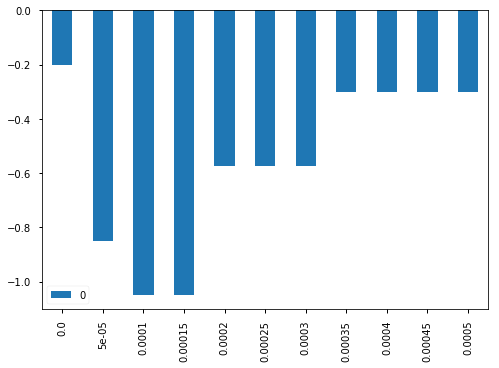

In [87]:
change_st_df = pd.DataFrame(change_st,index = sl_list)
change_st_df.plot.bar()

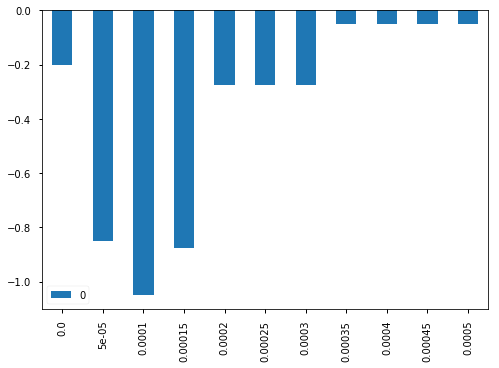

In [93]:
change_st_Mid = []
for i in range(11):
    pnl = OMMMid(sl_list[i],10)
    change_st_Mid.append(pnl)
change_st_Mid_df = pd.DataFrame(change_st_Mid,index = sl_list)
change_st_Mid_df.plot.bar()

In [92]:
change_st_Mid

[-0.20000000000131024]

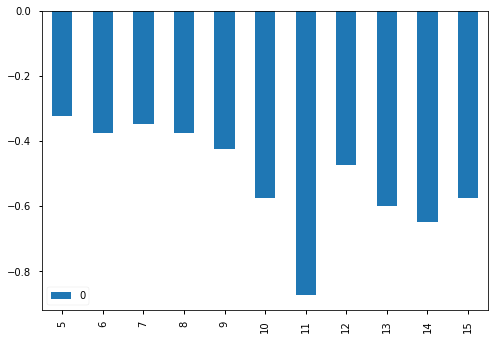

In [110]:
change_tte_side = []
for i in range(11):
    pnl = OMMSide(0.0002,tte_list[i])
    change_tte_side.append(pnl)
change_tte_side_df = pd.DataFrame(change_tte_side,index = tte_list)
change_tte_side_df.plot.bar()

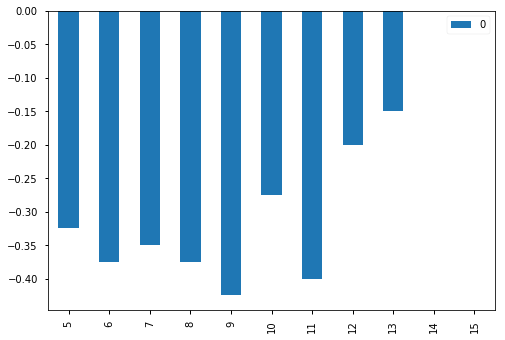

In [113]:
change_tte_mid = []
for i in range(11):
    pnl = OMMMid(0.0002,tte_list[i])
    change_tte_mid.append(pnl)
change_tte_mid_df = pd.DataFrame(change_tte_mid,index = tte_list)
change_tte_mid_df.plot.bar()